
=== Time Series Analysis ===
Original Soil Moisture Series:

=== Stationarity Check for Original Soil Moisture (mm) ===
ADF Statistic: -5.1055
p-value: 0.0000
The series IS stationary (reject H0)


<Figure size 1200x800 with 0 Axes>

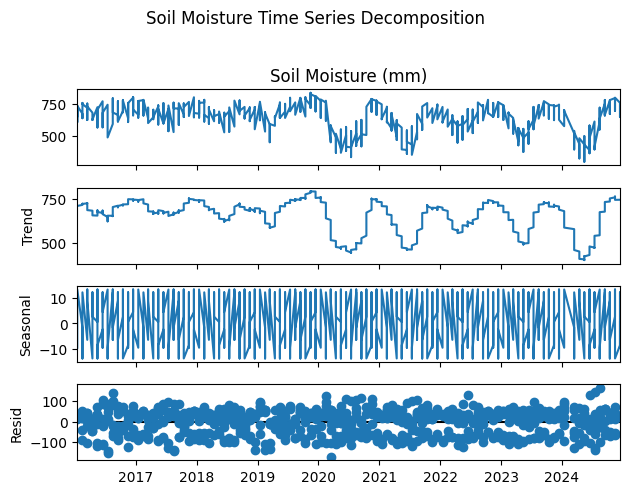


Seasonal component relative strength: 0.077
Weak or no seasonal pattern detected

=== Data Splits ===
Train dates: 2016-02-15 to 2023-02-15 (n=590)
Test dates: 2023-03-15 to 2024-01-15 (n=77)
Unseen dates: 2024-03-15 to 2024-12-15 (n=70)

Error during GridSearch: 'super' object has no attribute '__sklearn_tags__'

Falling back to default parameters...

=== Evaluation Results ===

Standard prediction on test set:
RMSE: 70.605 | MAE: 52.058 | AIC: 397201.594 | BIC: 861914.926

Standard prediction on unseen set:
RMSE: 85.492 | MAE: 66.114 | AIC: 397168.779 | BIC: 842984.677

Rolling forecast on test set:
RMSE: 73.364 | MAE: 54.823 | AIC: 397207.496 | BIC: 861920.828

Rolling forecast on unseen set:
RMSE: 90.846 | MAE: 70.442 | AIC: 397177.283 | BIC: 842993.180


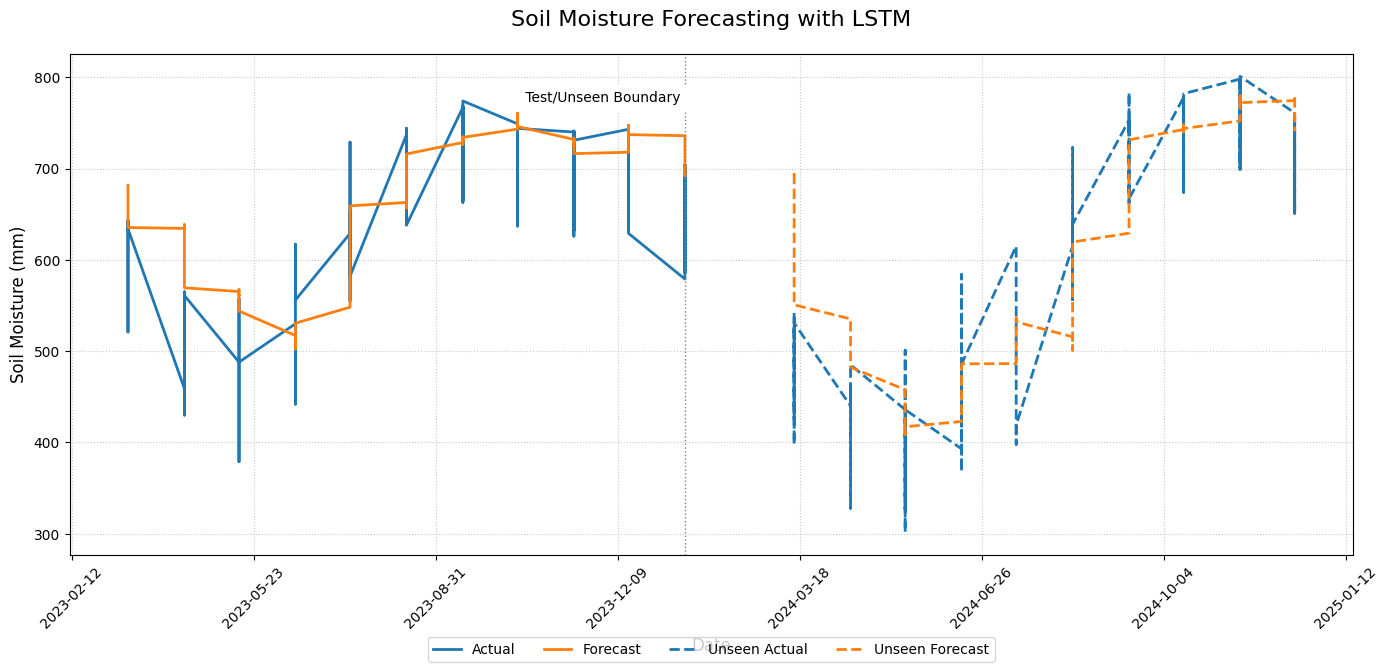

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.optimizers import Adam
from math import log
import tensorflow as tf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

# ------------------------------
# Utility Functions
# ------------------------------
def check_stationarity(series, series_name=""):
    """Perform ADF test and print results"""
    result = adfuller(series.dropna())
    test_stat, p_value = result[0], result[1]

    print(f"\n=== Stationarity Check for {series_name} ===")
    print(f"ADF Statistic: {test_stat:.4f}")
    print(f"p-value: {p_value:.4f}")

    if p_value < 0.05:
        print("The series IS stationary (reject H0)")
        return True
    else:
        print("The series is NOT stationary (fail to reject H0)")
        return False

def inverse_scale_predictions(y_pred_scaled, scaler, features):
    """Inverse transform scaled predictions"""
    return scaler.inverse_transform(
        np.hstack([np.zeros((len(y_pred_scaled), len(features))), y_pred_scaled.reshape(-1,1)])
    )[:, -1]

def rolling_forecast(model, initial_data, X_to_predict, window_size, features):
    """Make rolling window forecasts"""
    predictions = []
    history = list(initial_data)

    for i in range(len(X_to_predict)):
        input_seq = np.array(history[-1]).reshape((1, window_size, len(features)))
        pred_scaled = model.predict_on_batch(input_seq)[0][0]
        predictions.append(pred_scaled)
        new_observation = X_to_predict[i][-1].reshape(1, -1)
        next_input = np.vstack([history[-1][1:], new_observation])
        history.append(next_input)

    return inverse_scale_predictions(np.array(predictions), scaler, features)

def compute_metrics(y_true, y_pred, k):
    """Calculate evaluation metrics"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    rss = np.sum((y_true - y_pred)**2)
    mse = rss / len(y_true)
    aic = len(y_true) * log(mse) + 2 * k
    bic = len(y_true) * log(mse) + k * log(len(y_true))
    return rmse, mae, aic, bic

# ------------------------------
# 1. Load and Preprocess Data
# ------------------------------
data = pd.read_csv('Apayao.csv')

# Convert and filter dates
data['Date'] = pd.to_datetime(data['Time'], format='%m/%d/%Y')
data = data[data['Date'].dt.year >= 2016]
data = data.sort_values('Date')
data.set_index('Date', inplace=True)

# ------------------------------
# 2. Time Series Analysis
# ------------------------------
print("\n=== Time Series Analysis ===")
soil_moisture_series = data['Soil Moisture (mm)']
print("Original Soil Moisture Series:")
is_stationary = check_stationarity(soil_moisture_series, "Original Soil Moisture (mm)")

# Seasonality Analysis
try:
    decomposition = seasonal_decompose(soil_moisture_series.dropna(),
                                    model='additive',
                                    period=12)

    plt.figure(figsize=(12,8))
    decomposition.plot()
    plt.suptitle('Soil Moisture Time Series Decomposition', y=1.02)
    plt.tight_layout()
    plt.show()

    seasonal_strength = decomposition.seasonal.std() / soil_moisture_series.std()
    print(f"\nSeasonal component relative strength: {seasonal_strength:.3f}")

    if seasonal_strength > 0.4:
        print("Strong seasonal pattern detected")
    elif seasonal_strength > 0.1:
        print("Moderate seasonal pattern detected")
    else:
        print("Weak or no seasonal pattern detected")

except ValueError as e:
    print(f"Seasonal decomposition failed: {e}")

# ------------------------------
# 3. Prepare Data for Modeling
# ------------------------------
features = ['Soil Moisture (mm)']
target = 'Soil Moisture (mm)'

scaler = MinMaxScaler()
scaled = scaler.fit_transform(data[features + [target]])

X_all = scaled[:, :-1]
y_all = scaled[:, -1]

# Create sequences
window_size = 12
X_seq, y_seq = [], []
target_dates = data.index[window_size:]

for i in range(window_size, len(X_all)):
    X_seq.append(X_all[i-window_size:i, :])
    y_seq.append(y_all[i])

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# Split data
total_dates = data.index[window_size:]
split_date1 = total_dates[int(len(total_dates) * 0.8)]
split_date2 = total_dates[int(len(total_dates) * 0.9)]

train_idx = total_dates <= split_date1
test_idx = (total_dates > split_date1) & (total_dates <= split_date2)
unseen_idx = total_dates > split_date2

X_train, y_train = X_seq[train_idx], y_seq[train_idx]
dates_train = total_dates[train_idx]

X_test, y_test = X_seq[test_idx], y_seq[test_idx]
dates_test = total_dates[test_idx]

X_unseen, y_unseen = X_seq[unseen_idx], y_seq[unseen_idx]
dates_unseen = total_dates[unseen_idx]

print("\n=== Data Splits ===")
print(f"Train dates: {dates_train.min().date()} to {dates_train.max().date()} (n={len(X_train)})")
print(f"Test dates: {dates_test.min().date()} to {dates_test.max().date()} (n={len(X_test)})")
print(f"Unseen dates: {dates_unseen.min().date()} to {dates_unseen.max().date()} (n={len(X_unseen)})")

# ------------------------------
# 4. Build and Train LSTM Model
# ------------------------------
def build_model(units=128, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential([
        Input(shape=(window_size, len(features))),
        LSTM(units=units, return_sequences=True),
        Dropout(dropout_rate),
        LSTM(units=units),
        Dropout(dropout_rate),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mean_squared_error')
    return model

# Create the KerasRegressor with explicit sklearn compatibility
keras_reg = KerasRegressor(
    model=build_model,
    optimizer='adam',
    loss='mean_squared_error',
    epochs=50,
    batch_size=32,
    verbose=0,
    # Add these parameters for sklearn compatibility
    random_state=42,
    optimizer__learning_rate=0.001
)

# Update parameter grid
param_grid = {
    'model__units': [64, 128],
    'model__dropout_rate': [0.2, 0.3],
    'epochs': [50],
    'batch_size': [16, 32],
    'optimizer__learning_rate': [0.001, 0.01]
}

# Create TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

# Create GridSearchCV with error handling
try:
    grid = GridSearchCV(
        estimator=keras_reg,
        param_grid=param_grid,
        cv=tscv,
        scoring='neg_mean_squared_error',
        verbose=1,
        n_jobs=1  # Set to 1 to avoid potential multiprocessing issues
    )
    grid_result = grid.fit(X_train, y_train)
    best_model = grid_result.best_estimator_.model_

    print(f'\nBest Params: {grid_result.best_params_}')
    k = best_model.count_params()

except Exception as e:
    print(f"\nError during GridSearch: {e}")
    print("\nFalling back to default parameters...")
    # Fallback to a default model if GridSearch fails
    best_model = build_model()
    best_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    k = best_model.count_params()

# ------------------------------
# 5. Make Predictions
# ------------------------------
# Standard predictions
y_test_pred = inverse_scale_predictions(best_model.predict(X_test, verbose=0), scaler, features)
y_test_true = inverse_scale_predictions(y_test, scaler, features)

y_unseen_pred = inverse_scale_predictions(best_model.predict(X_unseen, verbose=0), scaler, features)
y_unseen_true = inverse_scale_predictions(y_unseen, scaler, features)

# Rolling forecasts
rolling_preds_test = rolling_forecast(best_model, list(X_train), X_test, window_size, features)
rolling_preds_unseen = rolling_forecast(best_model, list(np.vstack((X_train, X_test))), X_unseen, window_size, features)

# ------------------------------
# 6. Evaluate Results
# ------------------------------
metrics_test = compute_metrics(y_test_true, y_test_pred, k)
metrics_unseen = compute_metrics(y_unseen_true, y_unseen_pred, k)
metrics_roll_test = compute_metrics(y_test_true, rolling_preds_test, k)
metrics_roll_unseen = compute_metrics(y_unseen_true, rolling_preds_unseen, k)

print("\n=== Evaluation Results ===")
print(f"\nStandard prediction on test set:")
print(f"RMSE: {metrics_test[0]:.3f} | MAE: {metrics_test[1]:.3f} | AIC: {metrics_test[2]:.3f} | BIC: {metrics_test[3]:.3f}")

print(f"\nStandard prediction on unseen set:")
print(f"RMSE: {metrics_unseen[0]:.3f} | MAE: {metrics_unseen[1]:.3f} | AIC: {metrics_unseen[2]:.3f} | BIC: {metrics_unseen[3]:.3f}")

print(f"\nRolling forecast on test set:")
print(f"RMSE: {metrics_roll_test[0]:.3f} | MAE: {metrics_roll_test[1]:.3f} | AIC: {metrics_roll_test[2]:.3f} | BIC: {metrics_roll_test[3]:.3f}")

print(f"\nRolling forecast on unseen set:")
print(f"RMSE: {metrics_roll_unseen[0]:.3f} | MAE: {metrics_roll_unseen[1]:.3f} | AIC: {metrics_roll_unseen[2]:.3f} | BIC: {metrics_roll_unseen[3]:.3f}")

# ------------------------------
# 7. Visualize Results
# ------------------------------
plt.figure(figsize=(14, 7))

# Plot test period
plt.plot(dates_test, y_test_true, color='#1f77b4', linewidth=2, label='Test Actual')
plt.plot(dates_test, rolling_preds_test, color='#ff7f0e', linestyle='-', linewidth=2, label='Test Forecast')

# Plot unseen period
plt.plot(dates_unseen, y_unseen_true, color='#1f77b4', linestyle='--', linewidth=2, label='Unseen Actual')
plt.plot(dates_unseen, rolling_preds_unseen, color='#ff7f0e', linestyle='--', linewidth=2, label='Unseen Forecast')

# Add split line
split_date = dates_test[-1]
plt.axvline(x=split_date, color='gray', linestyle=':', linewidth=1)
plt.text(split_date, plt.ylim()[1]*0.95, ' Test/Unseen Boundary ',
         ha='right', va='top', backgroundcolor='white')

# Format plot
plt.title('Soil Moisture Forecasting with LSTM', fontsize=16, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Soil Moisture (mm)', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(handles=[
    plt.Line2D([0], [0], color='#1f77b4', lw=2, label='Actual'),
    plt.Line2D([0], [0], color='#ff7f0e', lw=2, label='Forecast'),
    plt.Line2D([0], [0], color='#1f77b4', lw=2, linestyle='--', label='Unseen Actual'),
    plt.Line2D([0], [0], color='#ff7f0e', lw=2, linestyle='--', label='Unseen Forecast')
], loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, frameon=True)

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(8))
plt.xticks(rotation=45)
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()